From Wikipedia: In contrast to the Pro Football and the National Baseball Halls of Fame, Springfield honors international and American professionals, as well as American and international amateurs, making it arguably the most comprehensive Hall of Fame among major sports. Since 2011, the induction process employs a total of seven committees to both screen and elect candidates.

First we need to import relevant packages/data. 

In [6]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from bs4 import BeautifulSoup as bs
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from imblearn.over_sampling import SMOTE
data = pd.read_csv('Seasons_Stats.csv')
new_data = pd.read_csv('new_data.csv')

Lets get a feel for the data. 

In [2]:
data.head()

,Unnamed: 0,Year,Player,Pos,Age,Tm,G,GS,MP,PER,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0,1950.0,Curly Armstrong,G-F,31.0,FTW,63.0,NaN,NaN,NaN,...,0.705,NaN,NaN,NaN,176.0,NaN,NaN,NaN,217.0,458.0
1,1,1950.0,Cliff Barker,SG,29.0,INO,49.0,NaN,NaN,NaN,...,0.708,NaN,NaN,NaN,109.0,NaN,NaN,NaN,99.0,279.0
2,2,1950.0,Leo Barnhorst,SF,25.0,CHS,67.0,NaN,NaN,NaN,...,0.698,NaN,NaN,NaN,140.0,NaN,NaN,NaN,192.0,438.0
3,3,1950.0,Ed Bartels,F,24.0,TOT,15.0,NaN,NaN,NaN,...,0.559,NaN,NaN,NaN,20.0,NaN,NaN,NaN,29.0,63.0
4,4,1950.0,Ed Bartels,F,24.0,DNN,13.0,NaN,NaN,NaN,...,0.548,NaN,NaN,NaN,20.0,NaN,NaN,NaN,27.0,59.0


In [3]:
data.shape

(24689, 53)

In [4]:
data.columns.values

array(['Unnamed: 0', 'Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS',
       'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%', 'USG%', 'blanl', 'OWS', 'DWS', 'WS',
       'WS/48', 'blank2', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS'], dtype=object)

We have 53 columns and 24,691 rows in our dataset. The rows consist of a player's individual season stats. 

Next, I want to get rid of players who are missing crucial statistics, so we need to store those player's names. 

In [5]:
invalid_players = []
for i in range(len(data)):
    if np.isnan(data['WS'][i]) == True or np.isnan(data['BPM'][i]) == True or np.isnan(data['VORP'][i]) == True or np.isnan(data['TRB'][i]) == True or np.isnan(data['AST'][i]) == True or np.isnan(data['STL'][i]) == True or np.isnan(data['BLK'][i]) == True or np.isnan(data['PTS'][i]) == True:
        invalid_players.append(data['Player'][i])
        
invalid_players = np.unique(invalid_players)
    


Columns 'Unnamed: 0', 'blanl' and 'blank2' have nothing in them, so lets get rid of them. 

In [6]:
data = data.drop(['Unnamed: 0','blanl','blank2'],axis=1)

In a new dataset, I store only the data that is extensive (aka not missing for a lot of players, and might be used in the model.) 

In [7]:
new_data = data[['Player','G','GS','MP','FG','WS','BPM','VORP','FGA','3P','3PA','2P','2PA','FT','FTA','ORB','DRB','TRB','AST','STL','BLK','TOV','PTS']]

In [8]:
new_data.head()

,Player,G,GS,MP,FG,WS,BPM,VORP,FGA,3P,...,FT,FTA,ORB,DRB,TRB,AST,STL,BLK,TOV,PTS
0,Curly Armstrong,63.0,NaN,NaN,144.0,3.5,NaN,NaN,516.0,NaN,...,170.0,241.0,NaN,NaN,NaN,176.0,NaN,NaN,NaN,458.0
1,Cliff Barker,49.0,NaN,NaN,102.0,2.2,NaN,NaN,274.0,NaN,...,75.0,106.0,NaN,NaN,NaN,109.0,NaN,NaN,NaN,279.0
2,Leo Barnhorst,67.0,NaN,NaN,174.0,3.6,NaN,NaN,499.0,NaN,...,90.0,129.0,NaN,NaN,NaN,140.0,NaN,NaN,NaN,438.0
3,Ed Bartels,15.0,NaN,NaN,22.0,-0.6,NaN,NaN,86.0,NaN,...,19.0,34.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,63.0
4,Ed Bartels,13.0,NaN,NaN,21.0,-0.6,NaN,NaN,82.0,NaN,...,17.0,31.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,59.0


Now I want to sum up the stats for each player (all seasons combined), and get rid of the players who are missing those crucial statistics. 

In [9]:
new_data = new_data.groupby('Player').sum().reset_index()
for i in invalid_players:
    new_data = new_data[new_data.Player.str.contains(i) == False]
    
new_data = new_data.reset_index()

The dataset has a * at the end of the players name if they were inducted into the Hall of Fame. So I want to look for this, and store 1 in a new column if the player was inducted, and a 0 if they were not.

I want to reduce the data a bit, I'm also going to get rid of players with less than 460 games because there has never been an NBA player who has made the hall of fame BECAUSE OF HIS NBA CAREER with less than 460 games played. Some players are in the hall of fame because of coaching prowless, or their success overseas. The basketball HOF does not only include NBA careers/players. 

In [10]:
hof = []
for i in range(len(new_data)):
    if '*' in new_data.iloc[i]['Player']:
        hof.append(1)
    else:
        hof.append(0) 

new_data['hof']=hof
invalid_players_2 = []
for i in range(len(new_data)):
    if new_data['G'][i] < 460:
        invalid_players_2.append(new_data['Player'][i])
    
for i in invalid_players_2:
    new_data = new_data[new_data.Player.str.match(i) == False]
    


In [52]:
new_data[new_data.hof==1].head()

,level_0,index,Player,G,GS,MP,FG,WS,BPM,VORP,...,league_mvp,scoring_champ,all_nba,finals_mvp,def_poy,stl_champ,ast_champ,trb_champ,blk_champ,retired
6,28,29,Adrian Dantley*,1107.0,613.0,39506.0,9217.0,154.0,43.7,50.0,...,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
15,56,72,Alex English*,1271.0,753.0,40464.0,11212.0,105.9,20.0,37.4,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18,73,92,Allen Iverson*,1064.0,1042.0,43303.0,9532.0,108.7,20.7,46.0,...,1.0,4.0,7.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0
21,79,98,Alonzo Mourning*,875.0,703.0,26677.0,5216.0,90.9,4.1,23.9,...,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,1.0
58,179,216,Artis Gilmore*,980.0,503.0,30578.0,5831.0,108.4,23.2,39.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


By utilizing the developer tools option in Chrome (F12), I was able to see how basketball-reference stored players and their corresponding url stem. So I downloaded the csv file and loaded it here. 

In [12]:
player_url = pd.read_csv('players_search_list.csv',header=-1)
player_url.columns = ['url_stem','name','yrs','misc']

In [13]:
player_url.head()

,url_stem,name,yrs,misc
0,greenac01,A.C. Green,1986-2001,0
1,bramlaj01,A.J. Bramlett,2000,0
2,engliaj01,A.J. English,1991-1992,0
3,guytoaj01,A.J. Guyton,2001-2003,0
4,hammoaj01,A.J. Hammons,2017,1


The next part is a bit complicated and the code probably isn't the most efficient but it sure gets the job done. 

First, I initialize new columns in the dataset because I'll be adding stuff there soon. 

I use the BeautifulSoup package in Python to scrape data. So we have the URL stem from the players_search_list.csv dataset, so we can use this to load the webpage using requests. Note that for Nene, the stem does not work for reasons unbeknownst to me. But given that it was one player, it was fine to manually load the page using an if statement. 

After the page is loading, we use BeautifulSoup to parse the page. Like before, using Developer Tools in Chrome I am able to look at the page's source code and see where the awards/accolades part is. The id is 'bling', and it is an unordered bulleted list (ul). 

If nothing is in that section, that means the player has no accolades, so store zeros in all of those columns I just created. 

If there are accolades in that section, store the text of the accolades in an array. Before moving on, I'd like to explain how the accolades are worded. If the player achieved the accolade more than once, then the text will read "14x All Star". We want the number "14" to be stored in the column, so we use Regex to strip all non-numeric characters using the re package in Python. 

Now that that is explained... this works by searching for certain keywords, and storing them if the keyword is contained in the text. If the keyword is contained in the text, then immediately move on to the next accolade in the array (by using continue). 

This code takes quite a while to run, since it needs to load and parse ~950 players' pages. 



In [ ]:
import re
import requests
new_data['all_star_appear'] = np.nan
new_data['nba_champ'] = np.nan
new_data['all_defensive']= np.nan
new_data['all_star_mvp'] = np.nan
new_data['league_mvp'] = np.nan
new_data['scoring_champ'] = np.nan
new_data['all_nba'] = np.nan
new_data['finals_mvp'] = np.nan
new_data['def_poy'] = np.nan
new_data['stl_champ'] = np.nan
new_data['ast_champ'] = np.nan
new_data['trb_champ'] = np.nan
new_data['blk_champ'] = np.nan
for counter, i in enumerate(new_data['Player']):
    if counter == 656:
        url = 'https://www.basketball-reference.com/players/h/hilarne01.html'
    else:
        stem = player_url[player_url['name'].str.contains(i)].reset_index().at[0,'url_stem']
        url = 'https://www.basketball-reference.com/players/'+stem[0]+'/'+stem+'.html'
    page = requests.get(url)
    soup = bs(page.content,'html.parser')
    if soup.find("ul",id='bling') is None:
        new_data.iloc[counter,25:] = 0
        continue
    else:
        body = soup.find("ul", id='bling').findAll('a')
    for award in body:
        result = re.sub('[^0-9]','', award.getText())
        if('All Star' in award.getText()): 
            new_data.at[new_data.index[counter], 'all_star_appear'] = result
            continue
        elif('NBA Champ' in award.getText()):
            new_data.at[new_data.index[counter], 'nba_champ'] = result
            continue
        elif('All-Defensive' in award.getText()):
            new_data.at[new_data.index[counter], 'all_defensive'] = result
            continue
        elif('AS MVP' in award.getText()):
            new_data.at[new_data.index[counter], 'all_star_mvp'] = result
            continue
        elif('Scoring Champ' in award.getText()):
            new_data.at[new_data.index[counter], 'scoring_champ'] = result
            continue
        elif('All-NBA' in award.getText()):
            new_data.at[new_data.index[counter], 'all_nba'] = result
            continue
        elif('Finals MVP' in award.getText()):
            new_data.at[new_data.index[counter], 'finals_mvp'] = result
            continue
        elif('STL Champ' in award.getText()):
            new_data.at[new_data.index[counter], 'stl_champ'] = result
            continue
        elif('TRB Champ' in award.getText()):
            new_data.at[new_data.index[counter], 'trb_champ'] = result
            continue
        elif('BLK Champ' in award.getText()):
            new_data.at[new_data.index[counter], 'blk_champ'] = result
            continue
        elif('AST Champ' in award.getText()):
            new_data.at[new_data.index[counter], 'ast_champ'] = result
            continue
        elif('Def. POY' in award.getText()):
            new_data.at[new_data.index[counter], 'def_poy'] = result
            continue

NaN is still stored in a row if a player has an accolade in one area, but not in another. So just fill all remaining NaN's to zero. 

In [15]:
new_data = new_data.fillna(0)

Before I mentioned how accolades will appear as "5x All Star" if they won it multiple times, but what happens if they only win it once? Well, instead of saying "1x All Star" it will say something like "1989-1990 All Star", which is the year. In this case, just replace anything that has a year in it to 1 (because if the year is present, that means they won that accolade only once). 

In [16]:
for i in new_data.columns[25:]:
    new_data[i][new_data[i] > 100000] = 1

The only thing I could not parse was league MVP awards, because of the way Python handles matching text (other accolades have the word "MVP" in it, which makes it difficult to parse). Instead of spending a long time trying to figure it out, I realized that manually entering league MVP values wouldn't even take that long, so that's what I did. 

In [17]:
new_data.loc[new_data.Player=='Russell Westbrook','league_mvp'] = 1
new_data.loc[new_data.Player=='Stephen Curry','league_mvp'] = 2
new_data.loc[new_data.Player=='Kevin Durant','league_mvp'] = 1
new_data.loc[new_data.Player=='LeBron James','league_mvp'] = 4
new_data.loc[new_data.Player=='Derrick Rose','league_mvp'] = 1
new_data.loc[new_data.Player=='Kobe Bryant','league_mvp'] = 1
new_data.loc[new_data.Player=='Dirk Nowitzki','league_mvp'] = 1
new_data.loc[new_data.Player=='Steve Nash','league_mvp'] = 2
new_data.loc[new_data.Player=='Kevin Garnett','league_mvp'] = 1
new_data.loc[new_data.Player=='Tim Duncan','league_mvp'] = 2
new_data.loc[new_data.Player=='Allen Iverson*','league_mvp'] = 1
new_data.loc[new_data.Player=='Shaquille O''Neal*','league_mvp'] = 1
new_data.loc[new_data.Player=='Karl Malone*','league_mvp'] = 2
new_data.loc[new_data.Player=='Michael Jordan*','league_mvp'] = 5
new_data.loc[new_data.Player=='David Robinson*','league_mvp'] = 1
new_data.loc[new_data.Player=='Hakeem Olajuwon*','league_mvp'] = 1
new_data.loc[new_data.Player=='Charles Barkley*','league_mvp'] = 1
new_data.loc[new_data.Player=='Magic Johnson*','league_mvp'] = 3
new_data.loc[new_data.Player=='Larry Bird*','league_mvp'] = 3
new_data.loc[new_data.Player=='Moses Malone*','league_mvp'] = 3
new_data.loc[new_data.Player=='Julius Irving*','league_mvp'] = 1
new_data.loc[new_data.Player=='Kareem Abdul-Jabbar*','league_mvp'] = 6
new_data.loc[new_data.Player=='Bill Walton*','league_mvp'] = 1
new_data.loc[new_data.Player=='Bob McAdoo*','league_mvp'] = 1
new_data.loc[new_data.Player=='Dave Cowens*','league_mvp'] = 1


Players are eligible for the hall of fame if they retired from the league for three years. 

To prepare for the test/train data split, I need to differentiate between players who are eligible and those who are not. Players who retired in 2013 (like Jason Kidd) are eligible for the first time this year, so I just use a simple conditional and store a '0' a newly-created "retired" column if the player is either still playing or retired after 2013, and a '1' if the player retired before 2014. 

In [194]:
player_url['retired'] = np.nan
new_data = new_data.reset_index()

for counter,year in enumerate(player_url.yrs):
    final_year = year[-4:]
    if final_year == '-' or int(final_year) <= 2012:
        player_url['retired'][counter] = 1
    else:
        player_url['retired'][counter] = 0

Now I'm storing the retired column in the dataset I have everything else in, also manually searching for invalid stems (like before) for 7 players.

In [195]:
new_data['retired'] = np.nan
for counter, i in enumerate(new_data.Player):
    if counter == 655:
        new_data['retired'][counter] = player_url.retired[player_url.url_stem == 'hilarne01'].reset_index().at[0,'retired']
    else:
        new_data['retired'][counter] = player_url[player_url['name'].str.contains(i)].reset_index().at[0,'retired']

Saving this dataset for future projects :)... also getting rid of Sabonis because he had more than 460 games in the NBA, but did not make the hall of fame because of his NBA efforts. He was a superstar overseas, but was not that great in the NBA.

In [196]:
new_data = new_data[new_data.Player != 'Arvydas Sabonis*']
new_data.to_csv('new_data.csv')

Splitting the data between players who are still playing (or retired after 2013), and players who are eligible for the hall of fame. 

In [3]:
eligible_players = new_data[new_data.retired == 1]
current_NBA_players = new_data[new_data.retired == 0]

Lets take a look at some boxplots for features we may use. This is for HoF eligible players only (since those players will be the ones in our training/test set)

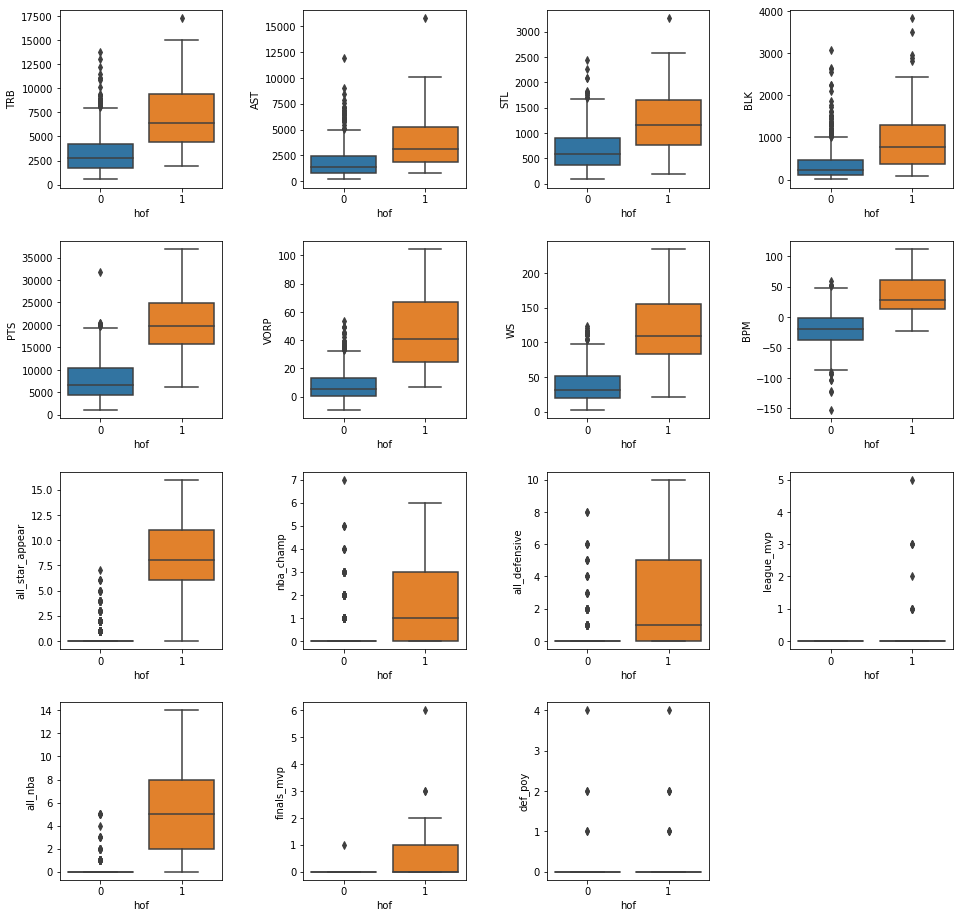

In [4]:
fig = plt.figure(figsize=(16,16))
for counter, column in enumerate(['TRB', 'AST', 'STL', 'BLK', 'PTS','VORP','WS','BPM',
       'all_star_appear', 'nba_champ', 'all_defensive',
       'league_mvp', 'all_nba', 'finals_mvp', 'def_poy']):
    plt.subplot(4,4,counter+1)
    plt.subplots_adjust(wspace=0.5,hspace=0.3)
    ax = sns.boxplot(x="hof", y=column, data=eligible_players)
    
plt.show()


For pretty much every single feature, hall-of-fame inductees have higher values than non hall-of-famers, so these will have large implications on whether a player gets into the hall-of-fame or not. 

Now, lets split the data into training and test datasets.

In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(eligible_players[['TRB', 'AST', 'STL', 'BLK', 'PTS', 'VORP','WS','BPM',
       'all_star_appear', 'nba_champ', 'all_defensive',
       'league_mvp', 'all_nba', 'def_poy', 'stl_champ', 'ast_champ','scoring_champ','blk_champ','trb_champ']], eligible_players['hof'], test_size=0.33)

LR = LogisticRegressionCV(cv=10,solver='liblinear')


I tried pretty much every classification model Python can throw at me, and Logistic Regression was consistently the best model to use (and gives nice probabilities), so we're gonna use a Logistic Regression model to predict future hall-of-famers. 

I'm also going rescale the data using StandardScaler() because of potential unit differences, it is good practice, and frankly it can't hurt. 

Also going to store features for our two new datasets (eligible players, and current players) so we can see what the model predicts later. 

In [54]:
X_NBA = current_NBA_players[['TRB', 'AST', 'STL', 'BLK', 'PTS','VORP','WS','BPM',
       'all_star_appear', 'nba_champ', 'all_defensive',
       'league_mvp', 'all_nba','def_poy','stl_champ', 'ast_champ','scoring_champ','blk_champ','trb_champ']]

X_retired = eligible_players[['TRB', 'AST', 'STL', 'BLK', 'PTS','VORP','WS','BPM',
       'all_star_appear', 'nba_champ', 'all_defensive',
       'league_mvp', 'all_nba', 'def_poy','stl_champ', 'ast_champ','scoring_champ','blk_champ','trb_champ']]

X_train_rescale = StandardScaler().fit_transform(X_train)



Fit the model to our training data, then predict the probabilities (and overall predictions) for the hall of fame for both current NBA players and retired players. If the probability is greater than 0.5, that means the model will predict the player will be inducted into the hall of fame, and vice versa for a probability less than 0.5. 

In [55]:
y_prob_LR_current_players = LR.fit(X_train_rescale, Y_train).predict_proba(StandardScaler().fit_transform(X_NBA))
y_pred_LR_current_players = LR.fit(X_train_rescale, Y_train).predict(StandardScaler().fit_transform(X_NBA))
y_prob_LR_retired_players = LR.fit(X_train_rescale, Y_train).predict_proba(StandardScaler().fit_transform(X_retired))
y_pred_LR_retired_players = LR.fit(X_train_rescale, Y_train).predict(StandardScaler().fit_transform(X_retired))

y_pred_LR = LR.fit(X_train_rescale, Y_train).predict(StandardScaler().fit_transform(X_test))



Store probabilities/predictions in our datasets for easy viewing later on. 

In [56]:
current_NBA_players['hof_prob'] = y_prob_LR_current_players[:,1]
current_NBA_players['hof_pred_LR'] = y_pred_LR_current_players

eligible_players['hof_prob'] = y_prob_LR_retired_players[:,1]
eligible_players['hof_pred_LR'] = y_pred_LR_retired_players


Lets see how our model does on the test data. It is better to use a confusion matrix and an f1 score because of the imbalanced nature of the dataset. 

In [50]:
confusion_matrix(y_pred_LR,Y_test)

array([[195,   3],
       [  0,  11]], dtype=int64)

In [51]:
print(classification_report(Y_test, y_pred_LR))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99       195
          1       1.00      0.79      0.88        14

avg / total       0.99      0.99      0.98       209



Pretty good! That's a decent f1-score. Now lets see what the model predicts for current NBA players (or players who have retired but are not eligible). 

In [52]:
current_NBA_players[['Player','hof_prob','hof_pred_LR']].sort_values(by='hof_prob',ascending=False).head(50)

,Player,hof_prob,hof_pred_LR
517,Kobe Bryant,1.000000,1
540,LeBron James,0.999996,1
500,Kevin Durant,0.999996,1
839,Tim Duncan,0.999986,1
503,Kevin Garnett,0.998755,1
272,Dwyane Wade,0.998468,1
255,Dirk Nowitzki,0.996582,1
763,Russell Westbrook,0.996118,1
131,Carmelo Anthony,0.979275,1
818,Steve Nash,0.978767,1


List of current players/recently retired players that the model predicts will be inducted into the hall of fame (for current players, given they retired today): 

Kobe Bryant, LeBron James, Kevin Durant, Tim Duncan, Kevin Garnett, Dwyane Wade, Russell Westbrook, Dirk Nowitzki, Stephen Curry, Steve Nash, Carmelo Anthony, Dwight Howard, James Harden, Ray Allen, Chris Bosh, Chris Paul, Jason Kidd, Paul Pierce, Tony Parker, Pau Gasol

List of notable/surprising current players/recently retired players that the model predicts will NOT be inducted into the hall of fame:

Vince Carter, Amar'e Stoudemire, Jermaine O'Neal, Grant Hill, Derrick Rose

Lets go into detail for each of these players above. 



VINCE CARTER:

Vince Carter is the only person on this list in which I vehemently disagree with the model. I believe that he is a future hall of famer. His peak was insane. The reason the model does not predict him to enter the hall of fame is because of his lack of playoff success and defensive ability. Despite being an 8 time All Star, 2 time All-NBA player, and scoring a copious amount of points in his career, he has not won an NBA championship, never lead in a major statistical category, and has no defensive accolades. 

AMAR'E STOUDEMIRE:

In terms of accolades, Amar'e Stoudemire was like Vince Carter. 6x All Star, 5x All-NBA, scored a lot of points, but no other accolades to mention. If he does get in, he certainly won't be a first-balloter. 

JERMAINE O'NEAL:

6x All Star, 3x All-NBA. If Amar'e is on the border of getting in, O'Neal for sure does not get in.

GRANT HILL: 

7x All Star, 5x All-NBA. Pretty similar to the last two. 

DERRICK ROSE:

Probably the most interesting cases to look at. Derrick Rose is a league MVP, and every league MVP in NBA history has made the hall of fame. So why wouldn't it be the same for Rose? After his insane 2010-2011 season in which he averaged 25 PPG, Rose has been on a sharp decline due to injury problems. He did not play in the entire 2012-2013 season due to an ACL tear, and since that season he has failed to average above 20 PPG. He only has 3 All Star appearances, and 1 All-NBA award. In my opinion, the model is correct -- Derrick Rose will be the first league MVP in NBA history to not make the hall of fame unless he makes a resurgence... but that is unlikely. 

